In [26]:
import numpy as np
import ast
from scipy.ndimage.filters import convolve
from scipy.signal import correlate
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image
from itertools import product, combinations
import cv2
import random

In [10]:
# Constants

w = 1
b = -1

In [11]:
def cartesian(arrays):
    if type(arrays[0]) == int:
        x = np.arange(arrays[0])
        y = np.arange(arrays[1])
    else:
        x = arrays[0]
        y = arrays[1]
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

In [12]:
def visualize_conv(input, filter, padding=False, full_wb_range=True, threshold=True):
    if padding:
        mode = 'same'
    else:
        mode = 'valid'   
    
    output = correlate(input, filter, mode=mode)
    ratio = input.shape[1] / filter.shape[1]
    max_value = np.sum(abs(filter)) * w
    
    if threshold:
        output = (output == max_value).astype(int)
     
    fig, axs = plt.subplots(1, 3, gridspec_kw = dict(width_ratios = [ratio,1,ratio]))
    axs[0].matshow(input, cmap=plt.cm.gray)
    axs[0].set_title('Input')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    
    axs[1].matshow(filter, cmap=plt.cm.gray, vmin=-1, vmax=1)
    axs[1].set_title('Filter')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    if full_wb_range:
        axs[2].matshow(output, cmap=plt.cm.gray)
    else:
        axs[2].matshow(output, cmap=plt.cm.gray, vmin=-max_value, vmax=max_value)
    axs[2].set_title('Output')
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    
    return output


In [117]:
# Basic input patterns

w = 1
b = -1

v_stripes = np.array([[b, w, b, w], 
                  [b, w, b, w],
                  [b, w, b, w],
                  [b, w, b, w]])

h_stripes = np.array([[b, b, b, b], 
                  [w, w, w, w],
                  [b, b, b, b],
                  [w, w, w, w]])

checker = np.array([[b, w, b, w],
                    [w, b, w, b],
                    [b, w, b, w],
                    [w, b, w, b]])

def get_rand_input(size=4):
    if type(size) == tuple:
        dims = size
    elif type(size) == int:
        dims = (size, size)
        
    mat = np.zeros(dims)    
            
    return np.random.choice([b,w],dims)


def get_edged_input(size=4):
    if type(size) == tuple:
        dims = size
    elif type(size) == int:
        dims = (size, size)
    
    which_edge = np.random.choice([0,1,2,3],(int(np.ceil(dims[0])/2), int(np.ceil(dims[1])/2)))
    
    first_tile = True
    
    mat = np.zeros(dims)
    
    for i, j in np.ndindex(dims):
        if i % 2 == 0 and j % 2 == 0:
            edge = which_edge[int(i / 2), int(j / 2)]
            if edge == 0:
                # Vertical edge b,w
                mat[i][j] = b
                mat[i][j+1] = w
                mat[i+1][j] = b
                mat[i+1][j+1] = w
            elif edge == 1:
                # Vertical edge w,b
                mat[i][j] = w
                mat[i][j+1] = b
                mat[i+1][j] = w
                mat[i+1][j+1] = b
            elif edge == 2:
                # Horizontal edge w,b
                mat[i][j] = w
                mat[i][j+1] = w
                mat[i+1][j] = b
                mat[i+1][j+1] = b
            else:
                # Horizontal edge w,b
                mat[i][j] = b
                mat[i][j+1] = b
                mat[i+1][j] = w
                mat[i+1][j+1] = w
                
    return mat
        
# 2x2 filters

v_edge_bw_22 = np.array([[-1, 1],
                      [-1, 1]])

h_edge_bw_22 = np.array([[-1, -1],
                      [1, 1]])

v_edge_wb_22 = np.array([[1, -1],
                      [1, -1]])

h_edge_wb_22 = np.array([[1, 1],
                      [-1, -1]])

edge_filters = [v_edge_bw_22, v_edge_wb_22, h_edge_bw_22, h_edge_wb_22]

diag1_22 = np.array([[1, -1],
                    [-1, 1]])

diag2_22 = np.array([[-1, 1],
                    [1, -1]])

diag_filters = [diag1_22, diag2_22]

black_corner_ul_22 = np.array([[-1, -1],
                              [-1, 1]])

black_corner_ur_22 = np.array([[-1, -1],
                              [1, -1]])

black_corner_ll_22 = np.array([[-1, 1],
                              [-1, -1]])

black_corner_lr_22 = np.array([[1, -1],
                              [-1, -1]])

black_corner_filters = [black_corner_ul_22, black_corner_ur_22, black_corner_ll_22, black_corner_lr_22] 

white_corner_ul_22 = black_corner_ul_22 * -1
white_corner_ur_22 = black_corner_ur_22 * -1
white_corner_ll_22 = black_corner_ll_22 * -1
white_corner_lr_22 = black_corner_lr_22 * -1

white_corner_filters = [white_corner_ul_22, white_corner_ur_22, white_corner_ll_22, white_corner_lr_22]

# 2x1 filters

bw_21 = np.array([[-1],
                   [1]])

bb_21 = np.array([[-1],
                    [-1]])

wb_21 = np.array([[1],
                [-1]])

ww_21 = np.array([[1],
                [1]])

filters_21 = [bw_21, bb_21, wb_21]

# 3x1 filters

www_31 = np.array([[1],
                   [1],
                   [1]])

wwb_31 = np.array([[1],
                   [1],
                   [-1]])

wbw_31 = np.array([[1],
                   [-1],
                   [1]])

bww_31 = np.array([[1],
                   [-1],
                   [1]])

wbb_31 = np.array([[1],
                   [-1],
                   [-1]])

bwb_31 = np.array([[-1],
                   [1],
                   [-1]])

bbw_31 = np.array([[-1],
                   [-1],
                   [1]])

bbb_31 = np.array([[-1],
                   [-1],
                   [-1]])

same_21 = np.array([[-1],
                    [-1]])

# 3x3 filters

v_edge_33 = np.array([[-1, 2, -1],
                      [-1, 2, -1],
                      [-1, 2, -1]])

h_edge_33 = np.array([[-1, -1, -1],
                      [2, 2, 2],
                      [-1, -1, -1]])

identity_33 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])

black_corner_ul_33 = np.array([[1, 1, 1],
                              [1, -1, -1],
                              [1, -1, 1]])

black_corner_ur_33 = np.array([[1, 1, 1],
                              [-1, -1, 1],
                              [1, -1, 1]])

black_corner_ll_33 = np.array([[1, -1, 1],
                              [1, -1, -1],
                              [1, 1, 1]])

black_corner_lr_33 = np.array([[1, -1, 1],
                              [-1, -1, 1],
                              [1, 1, 1]])

black_corner3_filters = [black_corner_ul_33, black_corner_ur_33, black_corner_ll_33, black_corner_lr_33]


def get_rand_filter(dims=(2,2)):
    return np.random.choice([1,-1], dims)

In [118]:
filter_dict = {'edge': edge_filters, 
           'diag': diag_filters, 
           'black_corner': black_corner_filters,
           'white_corner': white_corner_filters,
           'black_corner3': black_corner3_filters
}

filter_names_dict = {'edge': ['v_edge_bw_22', 'v_edge_wb_22', 'h_edge_bw_22', 'h_edge_wb_22'],
               'diag': ['diag1_22', 'diag2_22'],
                'black_corner': ['black_corner_ul', 'black_corner_ur', 'black_corner_ll', 'black_corner_lr'],
                'black_corner3': ['black_corner_ul_3', 'black_corner_ur_3', 'black_corner_ll_3', 'black_corner_lr_3'],     
                'white_corner': ['white_corner_ul', 'white_corner_ur', 'white_corner_ll', 'white_corner_lr']
               }

relative_position_dict = {1: '1 left of', 
                          2: '2 left of', 
                          3: '1 above',
                          4: '1 above and 1 left of',
                          5: '5 before',
                          6: '2 above', 
                          7: '2 above and 1 left of',
                          8: 'on the opposite corner of'}

## Sprites

In [129]:
def get_pyramid(grid_size = 4, size = 3):
    # pyramid_size = np.random.randint(3, grid_size + 1)
    x_start = np.random.randint(0, grid_size - size + 1)
    y_start = np.random.randint(grid_size - (size + 1)/2, grid_size)
    
    print(f"x_start:{x_start}, y_start:{y_start}")
    
    if type(grid_size) == tuple:
        dims = grid_size
    elif type(grid_size) == int:
        dims = (grid_size, grid_size)
        
    mat = np.ones(dims) * w
    level_size = size
    x = x_start
    y = y_start
    
    while level_size > 0:
        mat[y][x: (x + level_size)] = [b] * (level_size)
        
        level_size -= 2
        x += 1
        y -= 1
        
    return mat

def get_box(grid_size = 4, size = 4):
    # pyramid_size = np.random.randint(3, grid_size + 1)
    x_start = np.random.randint(0, grid_size - size + 1)
    y_start = np.random.randint(0, grid_size - size + 1)
    
    if type(grid_size) == tuple:
        dims = grid_size
    elif type(grid_size) == int:
        dims = (grid_size, grid_size)
        
    mat = np.ones(dims) * w
    x = x_start
    y = y_start
    
    for i in range(size):
        if y == y_start or y == y_start + size - 1:
            mat[y][x: (x + size)] = [b] * (size)
        else:
            mat[y][x] = b
            mat[y][x + size - 1] = b

        y += 1
        
    return mat

def get_ship(grid_size = 4, size = 3, centered = False):
    if centered:
        x_start = np.floor(grid_size / 2) -1 
        y_start = x_start
    else:
        x_start = np.random.randint(0, grid_size - size + 1)
        y_start = np.random.randint(0, grid_size - size + 1)
    
    if type(grid_size) == tuple:
        dims = grid_size
    elif type(grid_size) == int:
        dims = (grid_size, grid_size)
        
    mat = np.ones(dims) * w
    x = x_start
    y = y_start
    
    for i in range(3):
        if i % 2 == 0:
            mat[y][x:(x+size-1)] = [b] * (size - 1)
        else:
            mat[y][(x + size - 2):(x + size)] = [b] * 2

        y += 1
        
    return mat

def get_snake(grid_size = 5):
    height = random.choice(range(2, grid_size + 1))
    turn = random.choice(range(1, grid_size - 1))
    rising = random.choice([True, False])
    rotate = random.choice([True, False])
    
    print(f"Height: {height}, turn: {turn}, rising: {rising}, rotate: {rotate}")
    
    sprite = np.ones((height, grid_size))
    if rising:
        start = height - 1
        end = 0
    else:
        start = 0
        end = height - 1
    sprite[start, 0:(turn + 1)] = [b] * (turn + 1)
    sprite[end, turn:grid_size] = [b] * (grid_size - turn)
    sprite[:, turn] = [b] * height
    if rotate:
        sprite = (cv2.rotate(sprite, cv2.ROTATE_90_CLOCKWISE))
    
    mat = np.ones((grid_size, grid_size))
    sprite_height = sprite.shape[0]
    sprite_width = sprite.shape[1]
    start_i = random.choice(range(grid_size - sprite_height + 1))
    start_j = random.choice(range(grid_size - sprite_width + 1))
    mat[start_i:(start_i + sprite_height), start_j:(start_j + sprite_width)] = sprite 
    
    return mat

"""sprite_datasets_mult = {'pyramid': np.vstack([get_pyramid_dataset(7,3),get_pyramid_dataset(7,5)]),
                      'ship': get_ship_dataset(),
                  'box': np.vstack([get_box_dataset(7,3),get_box_dataset(7,4),get_box_dataset(7,5)])}
"""

"""
sprite_datasets = {'pyramid': get_pyramid_dataset(),
                      'ship': get_ship_dataset(),
                  'box': get_box_dataset()}
"""

sprite_examples = {'pyramid': get_pyramid, 
                 'ship': get_ship,
                 'box': get_box, 
                  'snake': get_snake}

In [21]:
def convolve_data(mat, filters):
    outputs = []
    for filter in filters:
        max_value = np.sum(abs(filter)) * w
        output = correlate(mat, filter, mode='valid')
        output = (output == max_value).astype(int)
        outputs.append(output.flatten())
    return np.vstack(outputs)

In [171]:
def generate_sprites(sprite_type, grid_size, rotate=False):
    if sprite_type == 'box':
        sprites = []
        for height, width in product(range(3, grid_size + 1), range(3, grid_size + 1)):
            mat = np.ones((height,width)) * w
            mat[0,:] = b
            mat[:,0] = b
            mat[height-1,:] = b
            mat[:,width-1] = b
            sprites.append(mat)
        return sprites
    
    if sprite_type == 'ship':
        sprites = []
        for size in range(3, grid_size + 1):
            mat = np.ones((3, size))
            mat[0] = [b] * size
            mat[1, size - 2 : size] = [b] * 2
            mat[2] = [b] * size
            sprites.append(mat)
            if rotate: 
                sprites = sprites + [cv2.rotate(mat, cv2.ROTATE_90_CLOCKWISE), cv2.rotate(mat, cv2.ROTATE_90_COUNTERCLOCKWISE), cv2.rotate(mat, cv2.ROTATE_180)]
        return sprites
    
    if sprite_type == "pyramid":
        sprites = []
        for size in range(3, grid_size + 1, 2):
            mat = np.ones((int((size + 1)/2), size))
            for i in range(int((size + 1)/2)):
                mat[i,int(((size - 1)/2  - i)):int(((size - 1)/2 + i + 1))] = b
            sprites.append(mat)
            if rotate:
                sprites = sprites + [cv2.rotate(mat, cv2.ROTATE_90_CLOCKWISE), cv2.rotate(mat, cv2.ROTATE_90_COUNTERCLOCKWISE), cv2.rotate(mat, cv2.ROTATE_180)]
        return sprites
    
    if sprite_type == "snake":
        sprites = []
        for height in range(2, grid_size + 1):
            for turn in range(1, grid_size - 1):
                for rising in [True, False]:
                    mat = np.ones((height, grid_size))
                    if rising:
                        start = height - 1
                        end = 0
                    else:
                        start = 0
                        end = height - 1
                    mat[start, 0:(turn + 1)] = [b] * (turn + 1)
                    mat[end, turn:grid_size] = [b] * (grid_size - turn)
                    mat[0:height, turn] = [b] * height
                    sprites.append(mat)
                    if rotate:
                        sprites.append(cv2.rotate(mat, cv2.ROTATE_90_CLOCKWISE))
        return sprites
    
    if sprite_type == "crazy_snake":
        sprites = []
        for height in range(2, grid_size + 1):
            for turn in range(1, grid_size - 1):
                for rising in [True, False]:
                    mat = np.ones((height, grid_size))
                    if rising:
                        start = height - 1
                        end = 0
                    else:
                        start = 0
                        end = height - 1
                    mat[start, 0:(turn + 1)] = [b] * (turn + 1)
                    mat[end, turn:grid_size] = [b] * (grid_size - turn)
                    mat[0:height, turn] = [b] * height
                    sprites.append(mat)
                    if rotate:
                        sprites.append(cv2.rotate(mat, cv2.ROTATE_90_CLOCKWISE))
        return sprites
        

def get_dataset(filter_types, sprite_types, grid_size = 4, same_row_col = False):
    if type(grid_size) == tuple:
        dims = grid_size
    elif type(grid_size) == int:
        dims = (grid_size, grid_size)
        
    mats = []
    
    sprites = []
    
    for sprite_type in sprite_types:
        current_data = generate_sprites(sprite_type, grid_size, rotate=True)
        sprites.append(current_data)
    
    y_list = []
    target = 0
    for sprite_type in sprites:
        for sprite in sprite_type:
            height = sprite.shape[0]
            width = sprite.shape[1]

            for x_start, y_start, in np.ndindex(grid_size - width + 1, grid_size - height + 1):
                mat = np.ones(dims) * w

                mat[y_start:y_start + height, x_start:x_start + width] = sprite
                mats.append(mat)
                y_list.append(target)
        
        target += 1
        
    X = np.array(mats)
    y = np.array(y_list)
    
    filters = []
    filter_names = []
    for filter_type in filter_types:
        filters = filters + filter_dict[filter_type]
        filter_names = filter_names + filter_names_dict[filter_type]
    
    X_conv = np.array([convolve_data(x, filters) for x in X])
    
    X_paired_list = []
    
    nfilters = X_conv.shape[1]
    size_conv = X_conv.shape[2]
    row_size = np.sqrt(size_conv)
    
    for x in X_conv:
        # x is a 2D array of size (nfilters, conv_grid_size) e.g. (4, 16)
        paired_activations = []
        # We want to iterate through all combinations of 2 of the 64 points and see if both are active
        for (i1, i2) in np.ndindex(nfilters, nfilters):          
            for diff in range(size_conv):
                found = False
                
                for start in range(size_conv - diff):
                    if x[i1, start] == x[i2, start + diff] == 1:
                        paired_activations.append(1)
                        found = True
                        break
                if not found:
                    paired_activations.append(0)
                    
        if same_row_col:        
            for (i1, i2) in combinations(range(nfilters), r=2):
                found_row = False
                active_f1 = [i for (i, el) in enumerate(x[i1]) if el == 1]
                active_f2 = [i for (i, el) in enumerate(x[i2]) if el == 1]
                for (i, j) in product(active_f1, active_f2):
                    if (i // grid_size == j // grid_size):
                        # Same row
                        paired_activations.append(1)
                        found_row = True
                        break
                if not found_row:
                    paired_activations.append(0)
                    
                
                found_col = False
                for (i, j) in product(active_f1, active_f2):
                    if (i % grid_size == j % grid_size + 1):
                        # Same col
                        paired_activations.append(1)
                        found_col = True
                        break
                        
                if not found_col:
                    paired_activations.append(0)
                
        X_paired_list.append(paired_activations)
    
    X_paired = np.vstack(X_paired_list)
    
    feature_names = []
    for (i1, i2) in np.ndindex(nfilters, nfilters):
        f1_name = filter_names[i1]
        f2_name = filter_names[i2]

        for diff in range(size_conv):
            if diff == 0:
                feature_names.append(f1_name)
                continue
            elif diff < row_size:
                pos_str = f" {diff} left of "
            elif diff % row_size == 0:
                pos_str = f" {diff // row_size} above "
            else:
                pos_str = f" {diff // row_size} above and {diff % row_size} left of "
            feature_names.append(f1_name + pos_str + f2_name)
    if same_row_col:  
        for (i1, i2) in combinations(range(nfilters), r=2):
            f1_name = filter_names[i1]
            f2_name = filter_names[i2]
            feature_names.append(f1_name + " same row as " + f2_name)
            feature_names.append(f1_name + " same column as " + f2_name)

    examples = [sprite_examples[sprite](grid_size=grid_size) for sprite in sprite_types]

    for mat in examples:
        for rotated_mat in [mat, cv2.rotate(mat, cv2.ROTATE_90_CLOCKWISE), cv2.rotate(mat, cv2.ROTATE_90_COUNTERCLOCKWISE), cv2.rotate(mat, cv2.ROTATE_180)]:
            for filter in filters:
                visualize_conv(rotated_mat, filter)

    return X, y, X_conv, X_paired, feature_names

Height: 2, turn: 1, rising: True, rotate: False


/Users/andrewkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


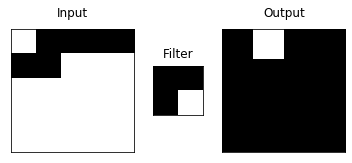

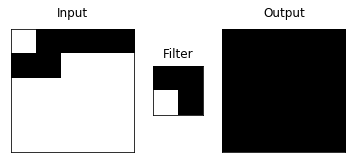

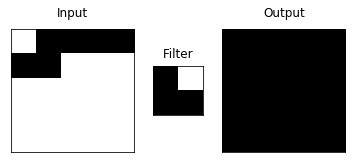

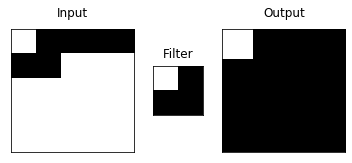

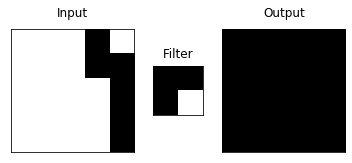

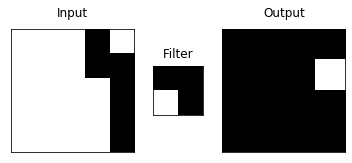

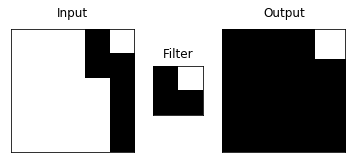

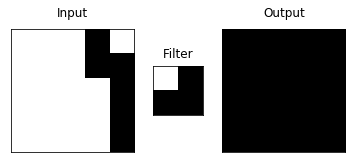

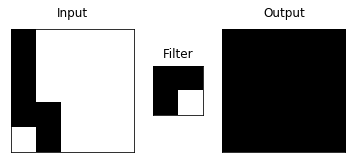

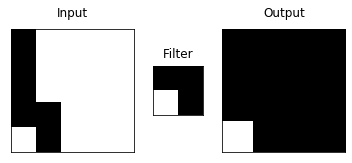

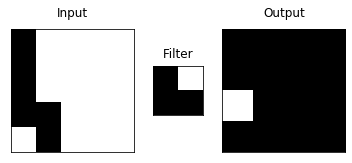

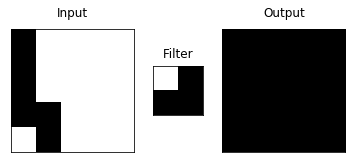

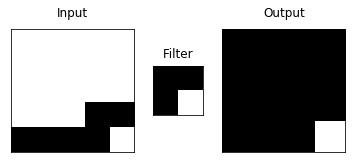

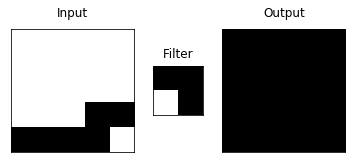

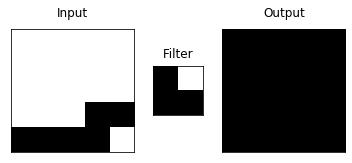

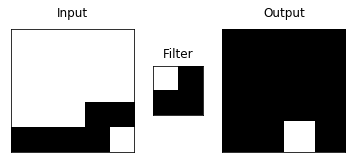

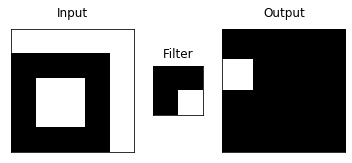

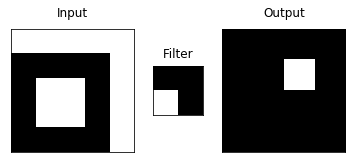

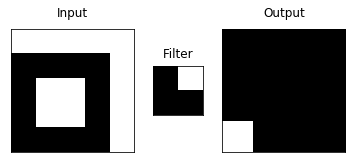

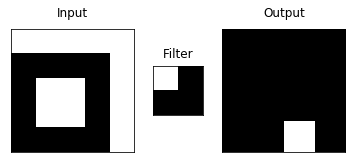

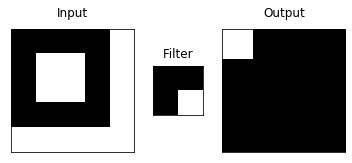

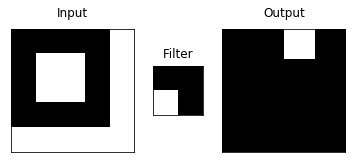

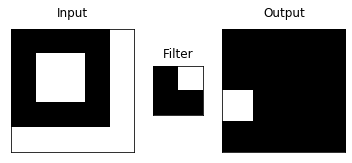

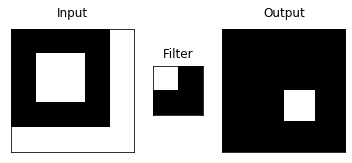

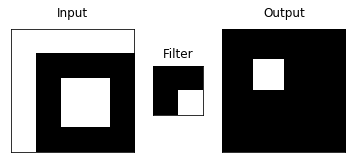

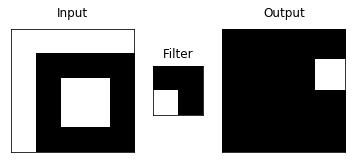

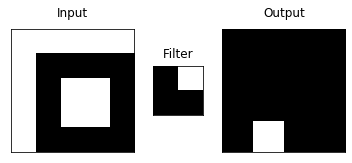

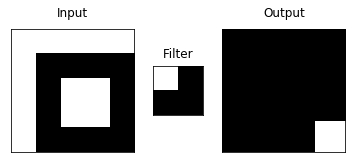

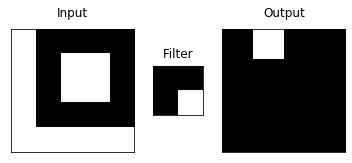

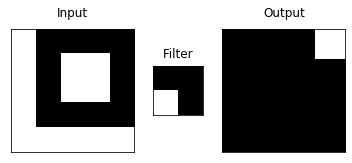

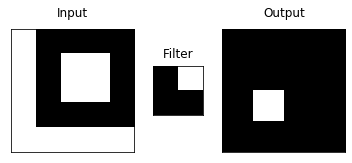

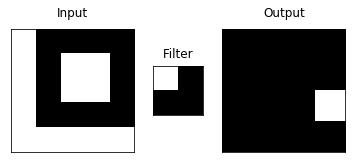

In [151]:
X, y, X_conv, X_paired, feature_names = get_dataset(['black_corner'],['snake', 'box'], 5, same_row_col=True)

In [19]:
"""sprite_datasets_mult = {'pyramid': np.vstack([get_pyramid_dataset(7,3),get_pyramid_dataset(7,5)]),
                      'ship': get_ship_dataset(),
                  'box': np.vstack([get_box_dataset(7,3),get_box_dataset(7,4),get_box_dataset(7,5)])}
"""

"""
sprite_datasets = {'pyramid': get_pyramid_dataset(),
                      'ship': get_ship_dataset(),
                  'box': get_box_dataset()}
"""

sprite_examples = {'pyramid': get_pyramid, 
                 'ship': get_ship,
                 'box': get_box}

In [14]:
class SpriteClassifier:
    def __init__(self):
        self.rule_dict = {}
        self.filter1 = None
        self.filter2 = None
        self.diff = 0
        self.target = -1
        
    def __filter_diff_match(self, x, f1, f2, diff):
        nfilters = x.shape[0]
        conv_size = x.shape[1]
        
        for i_start in range(conv_size - diff):
            if x[f1, i_start] == 1 and x[f2, i_start + diff] == 1:
                return True
        return False
    
    def fit(self, X, y):
        # Shape of X is (n, nfilters, convolution_size)
        nfilters = X.shape[1] 
        conv_size = X.shape[2]
        
        rule_found = False
        for diff in range(1, conv_size):
            for f1, f2 in product(range(nfilters), range(nfilters)):
                # For a given difference and set of two filters (possibly the same filters), check if all x can be classified correctly
                matches = [self.__filter_diff_match(x, f1, f2, diff) for x in X]
                
                self.rule_dict[(f1, f2, diff)] = matches
                
                if all(matches == y):                   
                    self.filter1 = f1
                    self.filter2 = f2
                    self.diff = diff
                    self.target = 1
                    
                    rule_found = True
                    print("Rule found!")
                    break
                    
                elif all(np.invert(matches) == y):
                    self.filter1 = f1
                    self.filter2 = f2
                    self.diff = diff
                    self.target = 0
                    
                    rule_found = True
                    print("Rule found!")
                    break
            
            if rule_found:
                break
                
        if not rule_found:
            for rule1 in self.rule_dict:
                for rule2 in self.rule_dict:
                    joint_matches = [x or y for (x, y) in zip(self.rule_dict[rule1], self.rule_dict[rule2])]
                    if all(joint_matches == y):
                        self.rule_dict = {
                            rule1: self.rule_dict[rule1],
                            rule2: self.rule_dict[rule2],
                            target: 1
                        }
                    elif all(np.invert(joint_matches) == y):
                        self.rule_dict = {
                            rule1: self.rule_dict[rule1],
                            rule2: self.rule_dict[rule2],
                            target: 0
                        }
        
        
        if not rule_found:
            print("No rule found!")

    def __classify_input(self, x, y):
        if self.__filter_diff_match(x, self.f1, self.f2, self.diff):
            return self.target
        else:
            return 1 - self.target
        
    def predict(self, X):
        return np.array([self.__classify_input(X[i], y[i]) for i in range(X.shape[0])])
        
    

In [15]:
def get_data(filter_types, sprite_types, grid_size=4, mult=False):
    
    X_list = []
    y_list = []
    target = 0
    for sprite in sprite_types:  
        if mult:
            sprite_data = sprite_datasets_mult[sprite]
        else:
            sprite_data = sprite_datasets[sprite]
        X_list.append(sprite_data)
        y_list = y_list + sprite_data.shape[0] * [target]
        target += 1
        
    X = np.vstack(X_list)
    y = np.array(y_list)
    
    filters = []
    filter_names = []
    for filter_type in filter_types:
        filters = filters + filter_dict[filter_type]
        filter_names = filter_names + filter_names_dict[filter_type]

    X_conv = np.array([convolve_data(x, filters) for x in X])

    examples = [sprite_examples[sprite](grid_size=grid_size, size=5) for sprite in sprite_types]

    for mat in examples:
        for filter in filters:
            visualize_conv(mat, filter)

    return X, y, X_conv, filter_names
    

## SpriteClassifier

In [16]:
filters = ['black_corner', 'white_corner', 'edge']
sprites = ['box', 'pyramid']

X, y, X_conv, filter_names = get_dataset(filters, sprites, grid_size=5)

clf = SpriteClassifier()
clf.fit(X_conv, y)

f1_name = filter_names[clf.filter1]
f2_name = filter_names[clf.filter2]

print(f"Rule: {f1_name} {relative_position_dict[clf.diff]} {f2_name} -> {sprites[clf.target]}")

NameError: name 'sprite_examples' is not defined

Rule found!
Rule: black_corner_lr 1 left of black_corner_ll -> pyramid


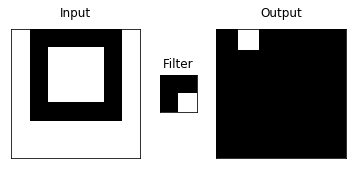

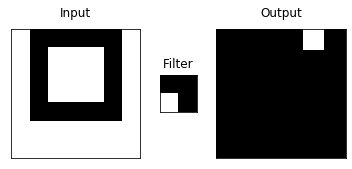

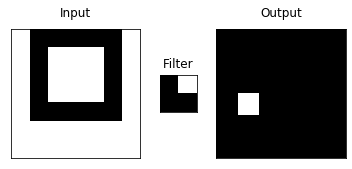

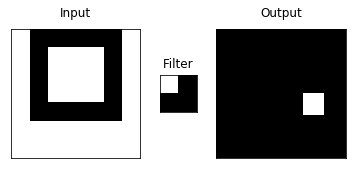

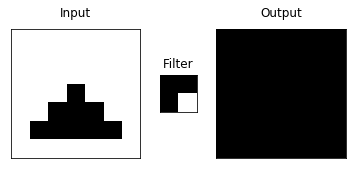

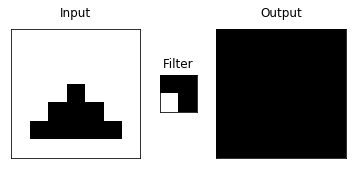

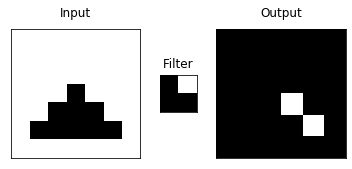

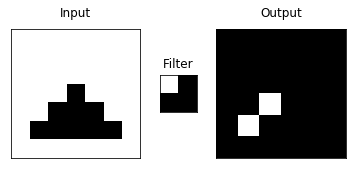

In [53]:
filters = ['black_corner']
sprites = ['box', 'pyramid']

X, y, X_conv, filter_names = get_data(filters, sprites, grid_size=7, mult=True)

clf = SpriteClassifier()
clf.fit(X_conv, y)

f1_name = filter_names[clf.filter1]
f2_name = filter_names[clf.filter2]

print(f"Rule: {f1_name} {relative_position_dict[clf.diff]} {f2_name} -> {sprites[clf.target]}")

No rule found!


TypeError: list indices must be integers or slices, not NoneType

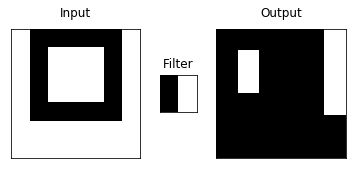

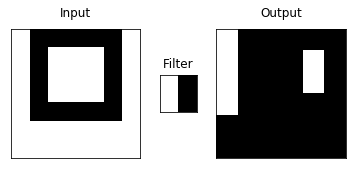

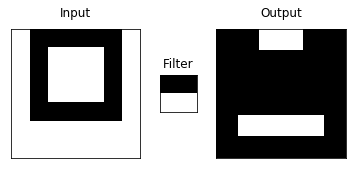

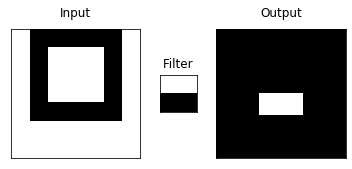

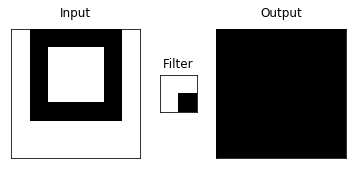

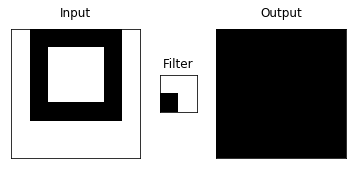

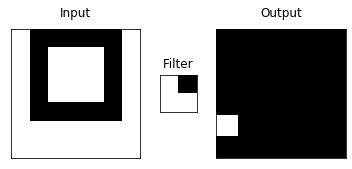

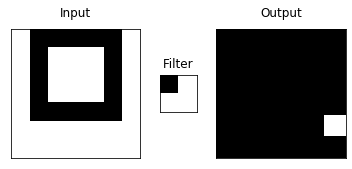

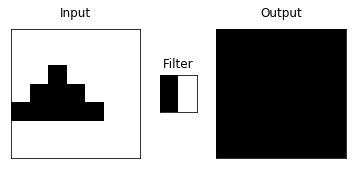

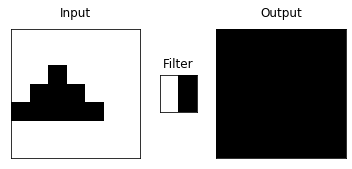

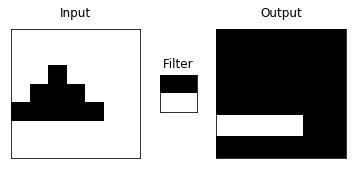

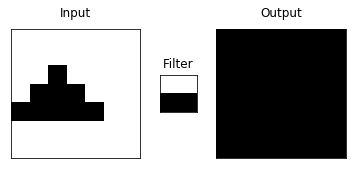

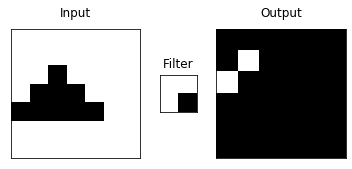

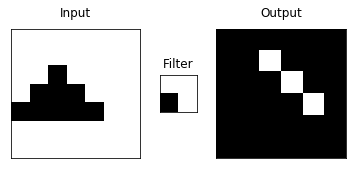

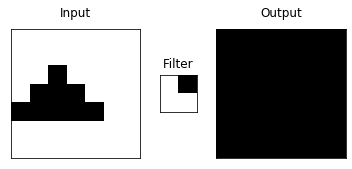

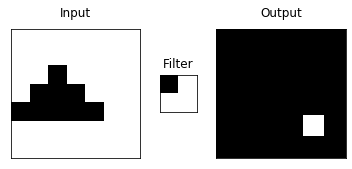

In [59]:
filters = ['edge', 'white_corner']
sprites = ['box', 'pyramid']

X, y, X_conv, filter_names = get_data(filters, sprites, grid_size=7, mult=True)

clf = SpriteClassifier()
clf.fit(X_conv, y)

f1_name = filter_names[clf.filter1]
f2_name = filter_names[clf.filter2]

print(f"Rule: {f1_name} {relative_position_dict[clf.diff]} {f2_name} -> {sprites[clf.target]}")

## Decision Tree

In [133]:
def show_decision_tree(filter_types, sprite_types, max_depth=3, grid_size=4, same_row_col=False):

    X, y, X_conv, X_paired, feature_names = get_dataset(filter_types, sprite_types, grid_size, same_row_col)
    # Fit the decision tree
    
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_paired, y)
    
    # Display decision tree
    
    export_graphviz(clf, out_file="tree.dot", feature_names=feature_names, class_names= sprite_types)

    !dot -Tpng tree.dot -o tree.png
    
    Image(filename="tree.png")

Height: 4, turn: 4, rising: True, rotate: False


/Users/andrewkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


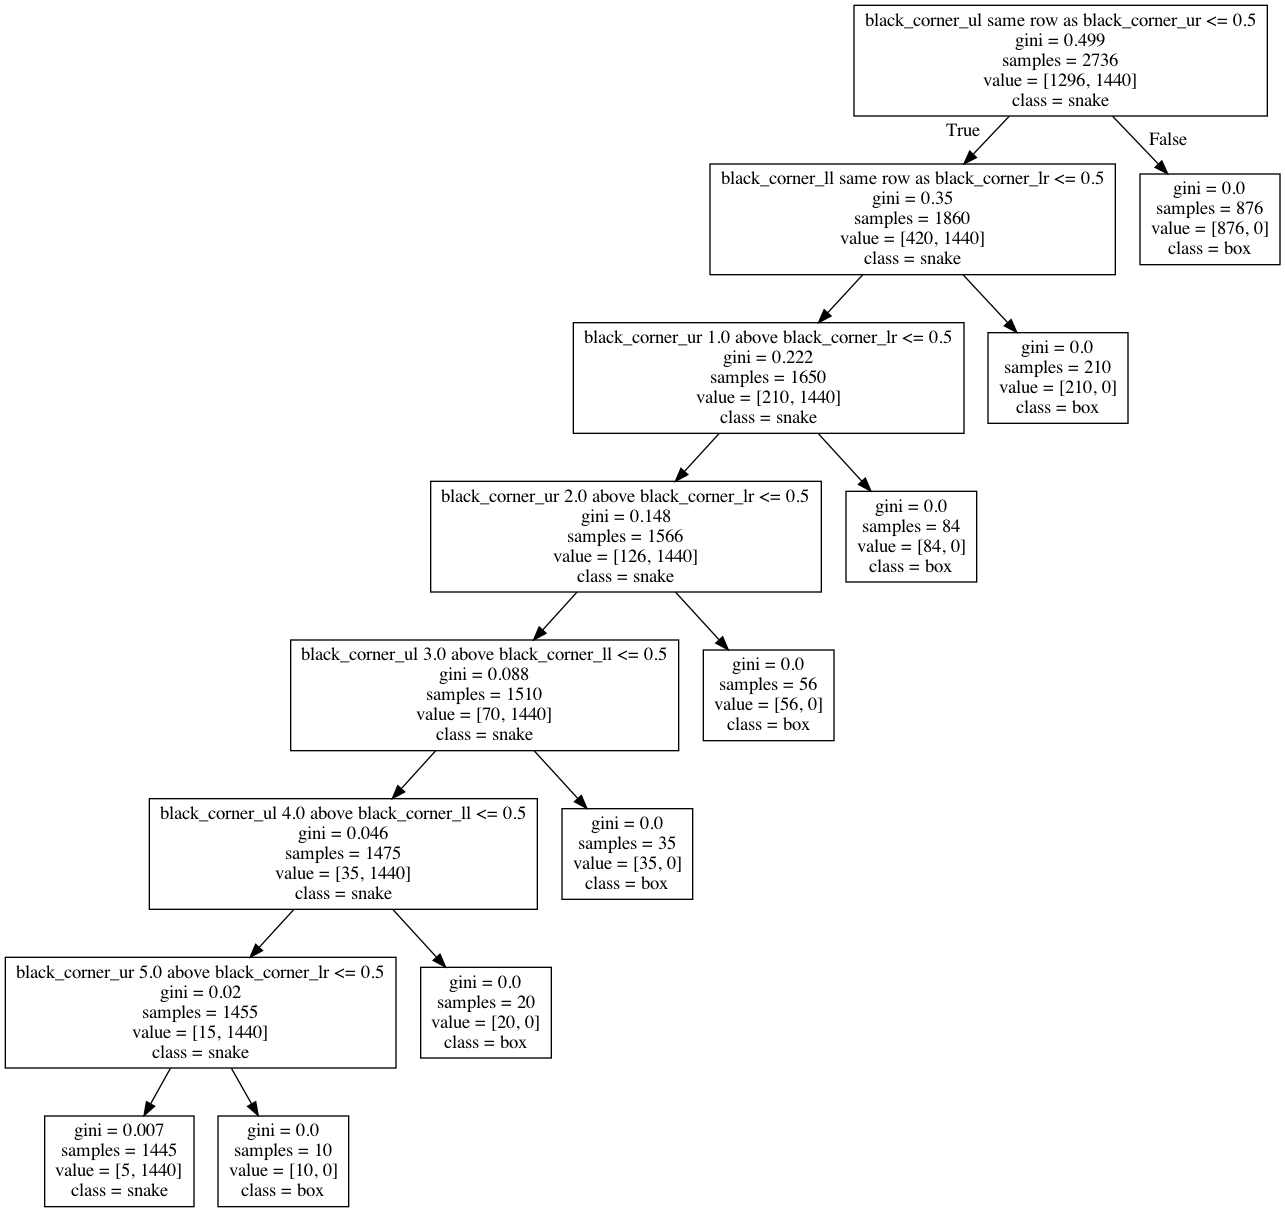

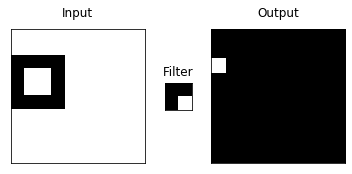

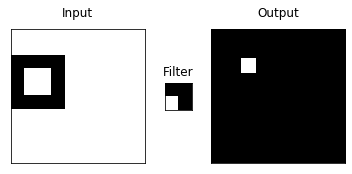

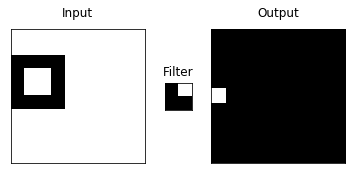

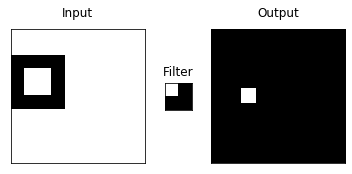

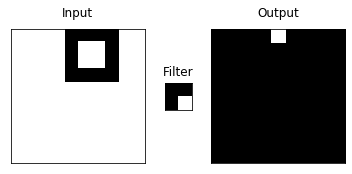

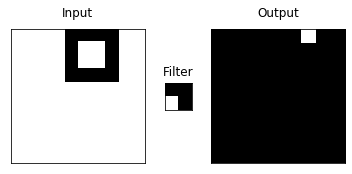

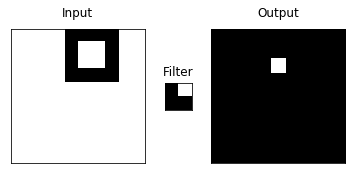

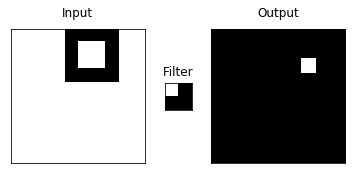

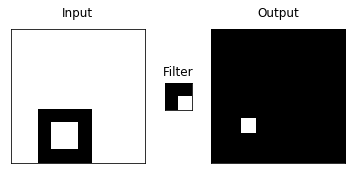

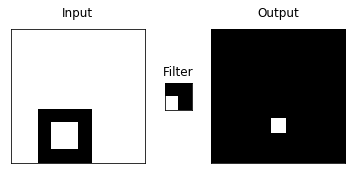

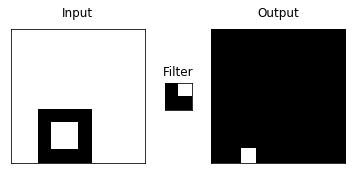

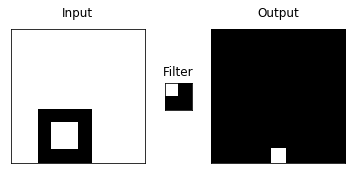

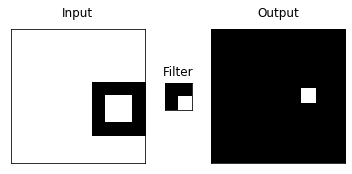

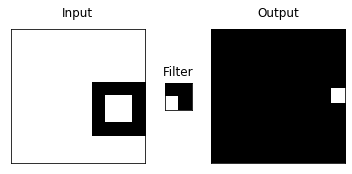

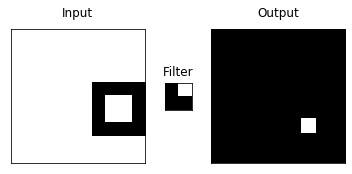

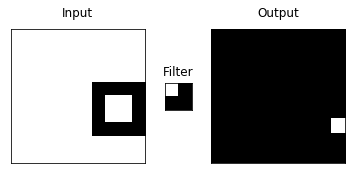

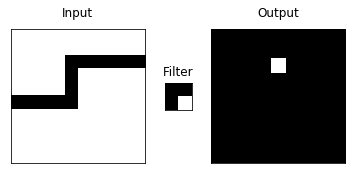

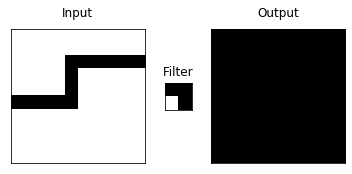

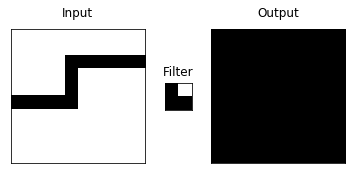

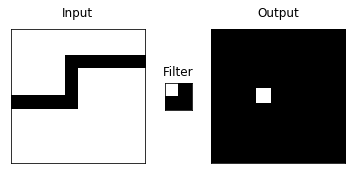

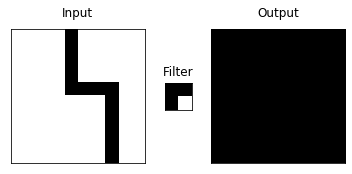

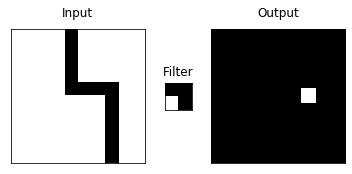

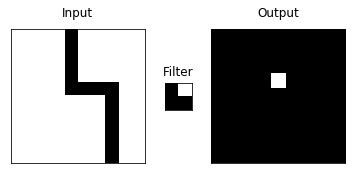

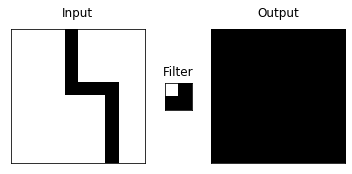

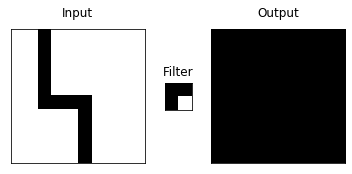

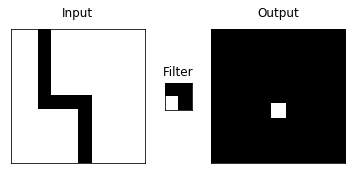

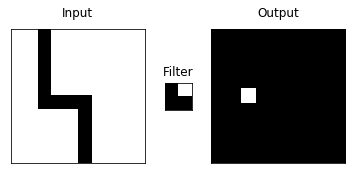

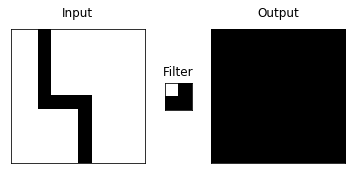

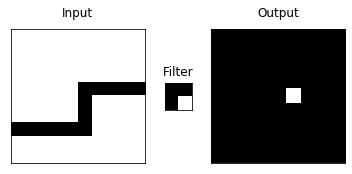

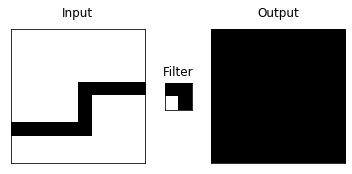

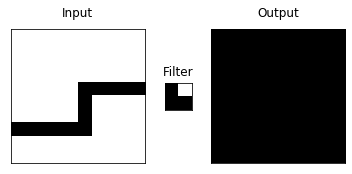

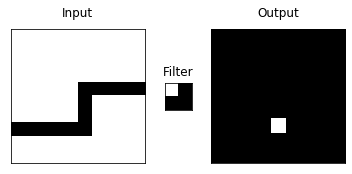

In [180]:
filters_types = ['black_corner']
sprite_types = ['box', 'snake']

show_decision_tree(filters_types, sprite_types, max_depth=7, grid_size=10, same_row_col=True)
Image(filename="tree.png")

Height: 5, turn: 1, rising: False, rotate: True


/Users/andrewkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


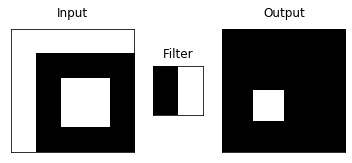

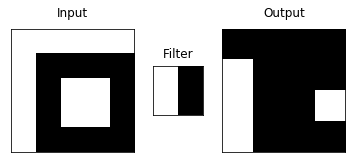

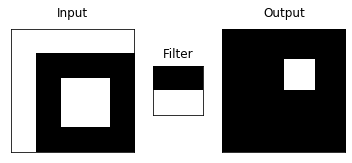

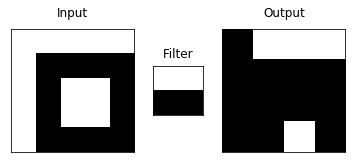

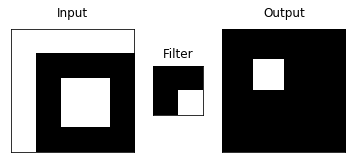

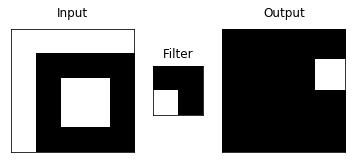

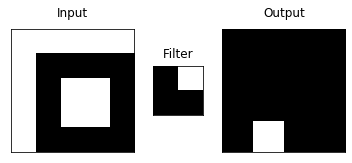

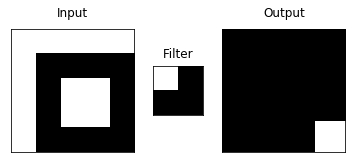

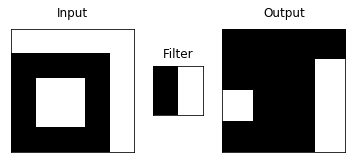

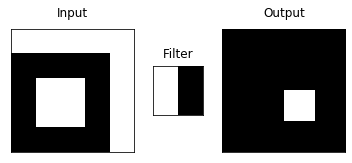

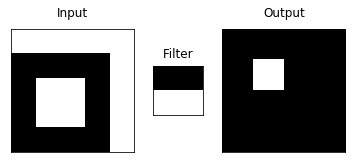

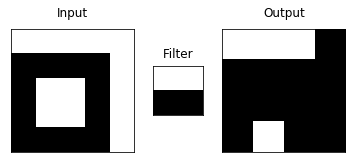

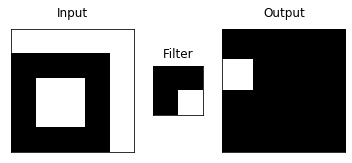

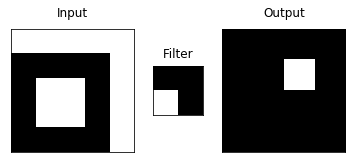

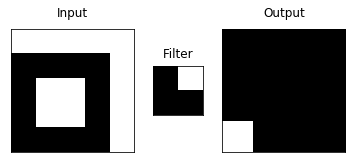

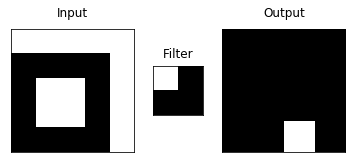

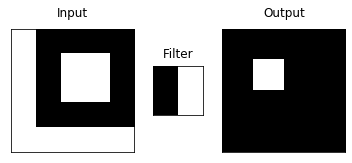

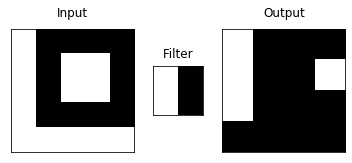

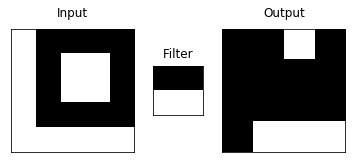

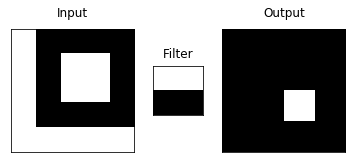

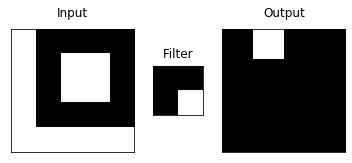

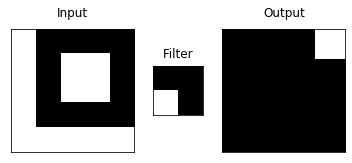

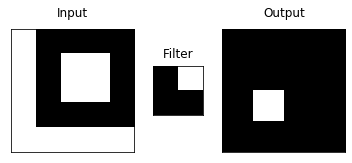

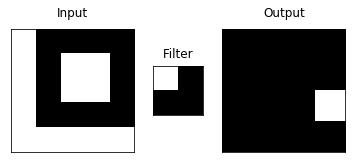

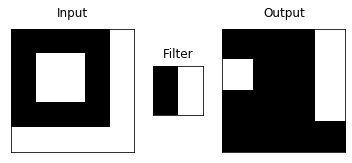

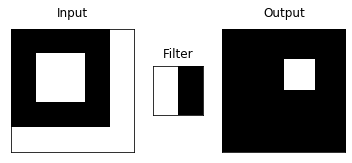

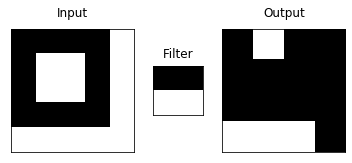

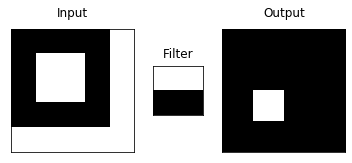

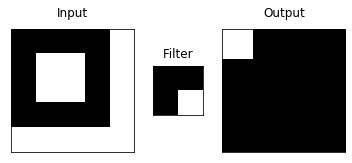

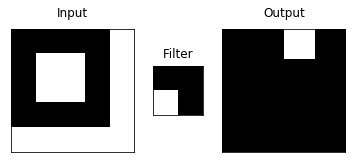

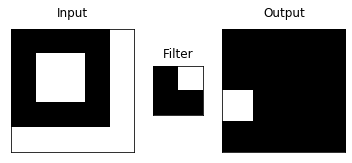

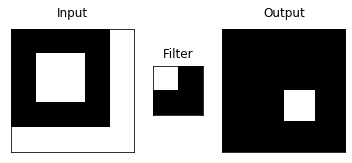

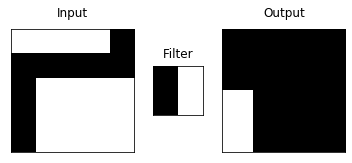

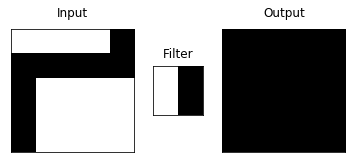

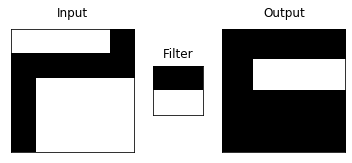

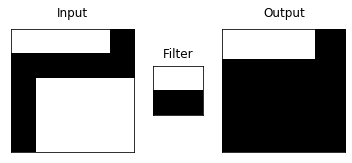

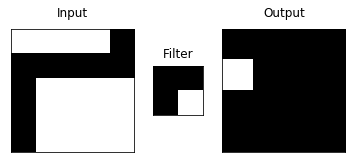

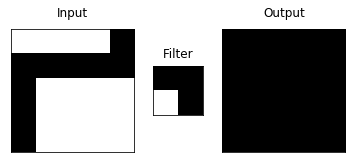

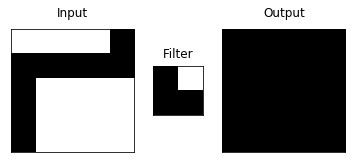

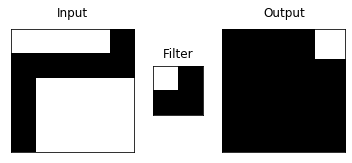

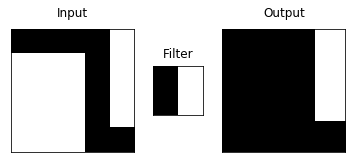

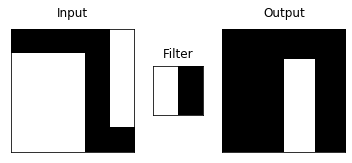

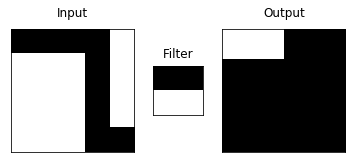

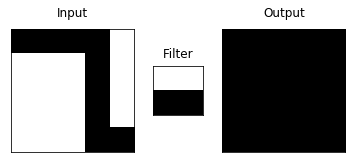

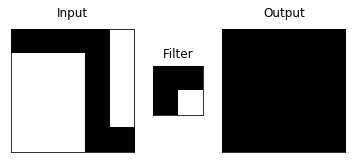

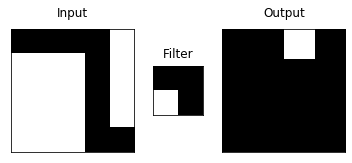

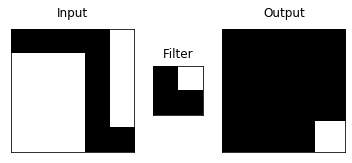

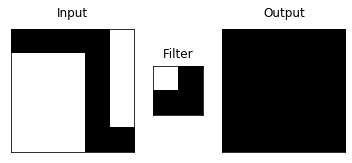

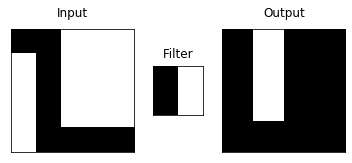

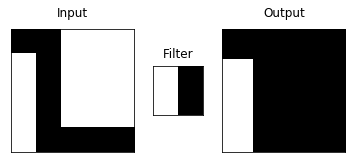

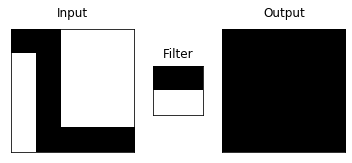

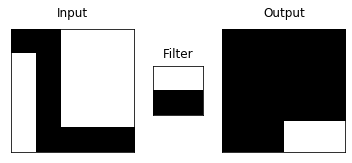

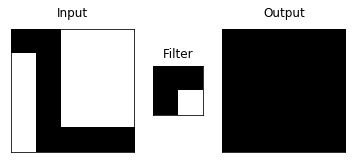

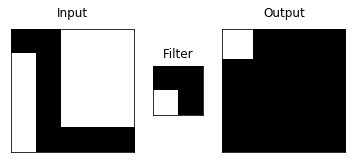

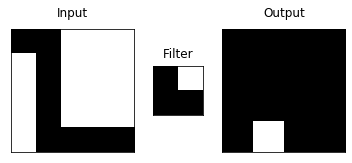

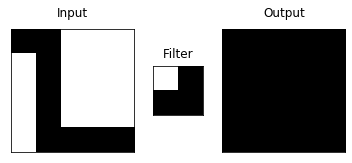

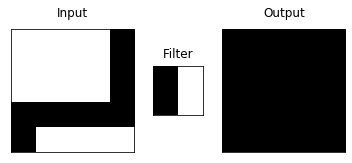

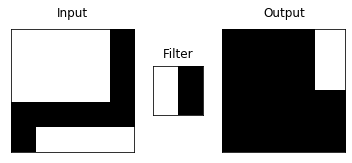

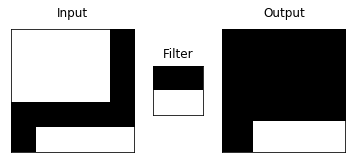

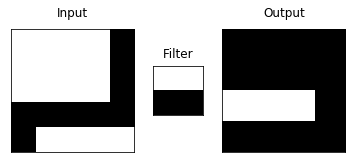

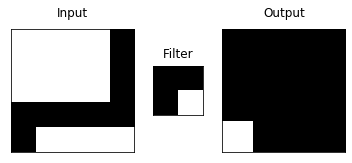

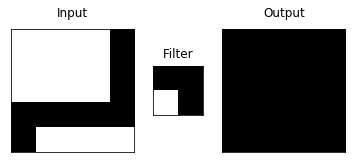

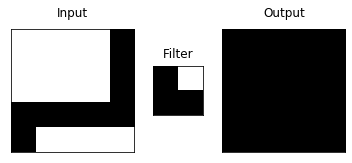

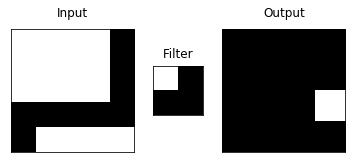

In [93]:
filter_types = ['edge', 'black_corner']
sprite_types = ['box', 'snake']
grid_size = 5
max_depth = 5

X, y, X_conv, X_paired, feature_names = get_dataset(filter_types, sprite_types, grid_size)
# Fit the decision tree

clf = tree.DecisionTreeClassifier(max_depth = max_depth)
clf.fit(X_paired, y)
X_wrong = X[y != clf.predict(X_paired)]
    

In [94]:
X_wrong.shape

(28, 5, 5)

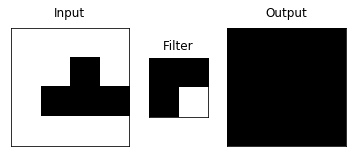

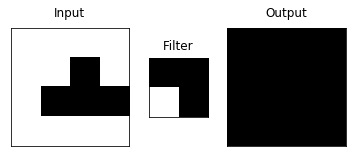

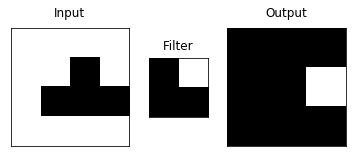

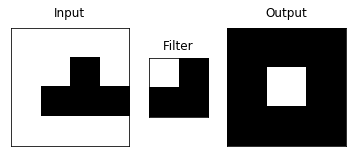

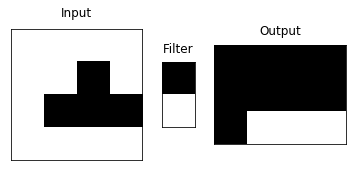

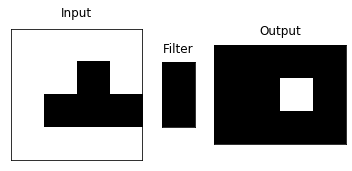

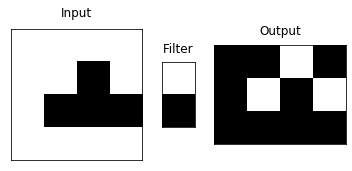

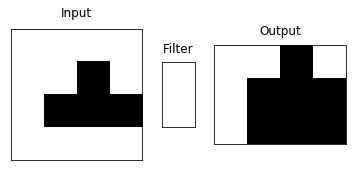

In [74]:
input = get_pyramid()
    
for filter in black_corner_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in filters_21:
    visualize_conv(input, filter, threshold = True)

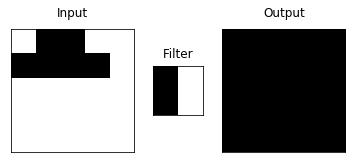

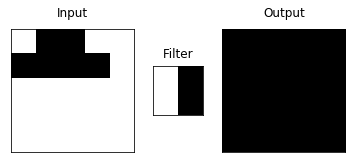

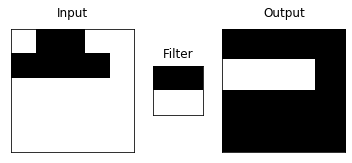

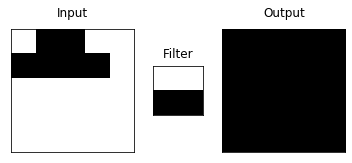

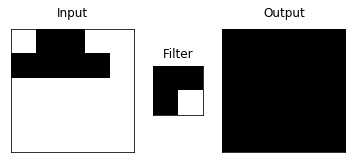

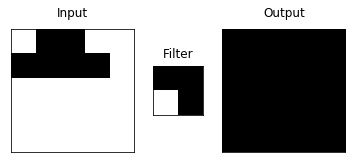

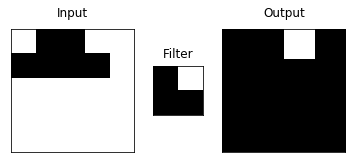

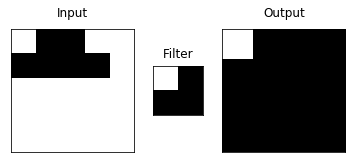

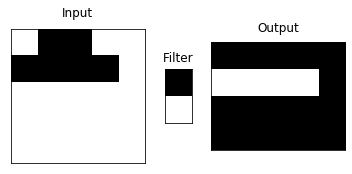

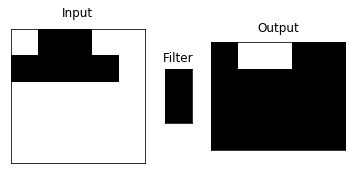

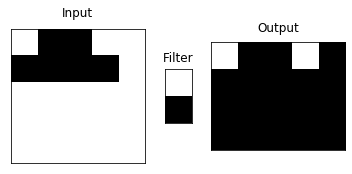

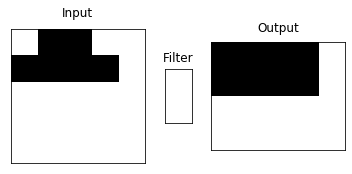

In [101]:
input = get_pyramid(5, 4)

for filter in edge_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in black_corner_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in filters_21:
    visualize_conv(input, filter, threshold = True)

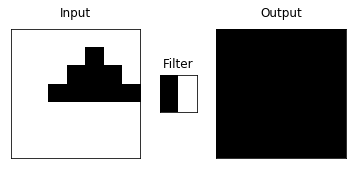

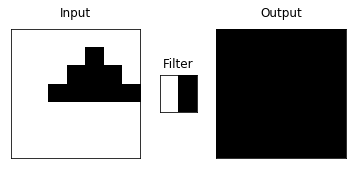

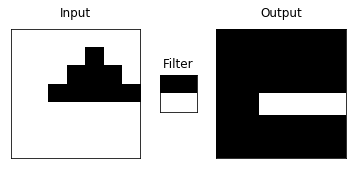

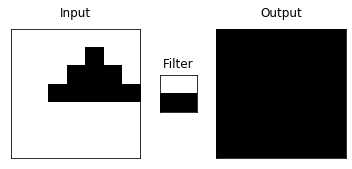

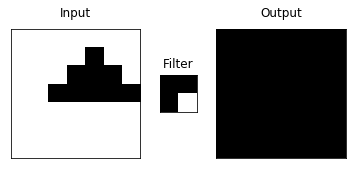

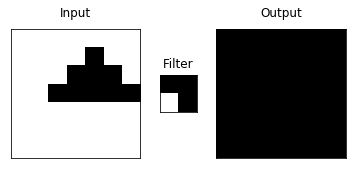

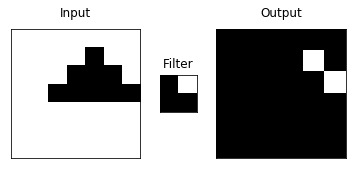

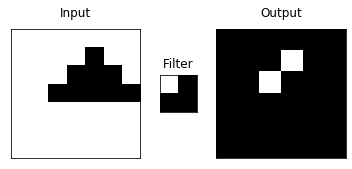

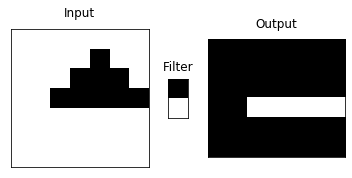

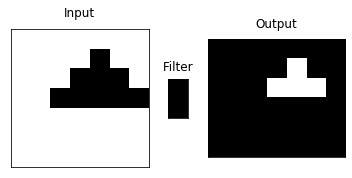

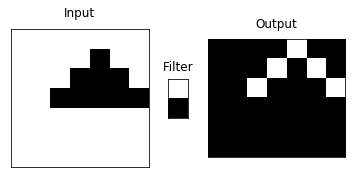

In [105]:
input = get_pyramid(7, 5)

for filter in edge_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in black_corner_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in filters_21:
    visualize_conv(input, filter, threshold = True)

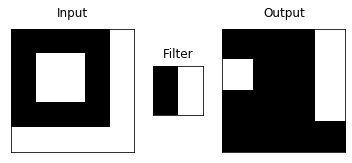

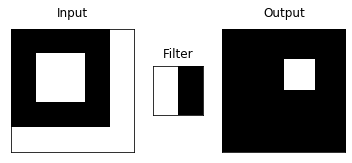

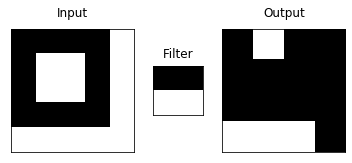

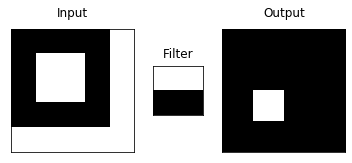

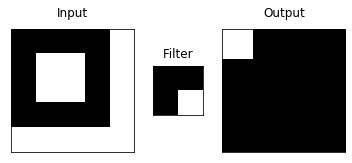

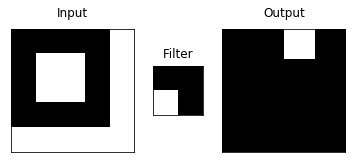

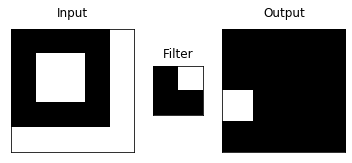

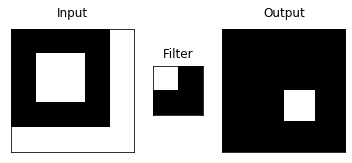

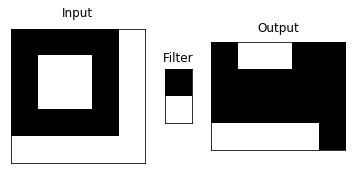

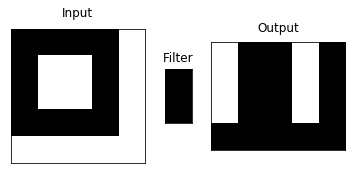

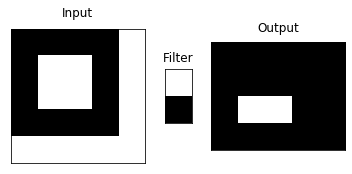

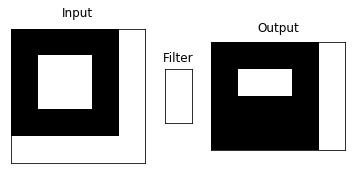

In [99]:
input = get_box(5,4)

for filter in edge_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in black_corner_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in filters_21:
    visualize_conv(input, filter, threshold = True)

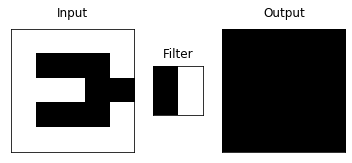

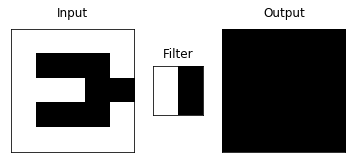

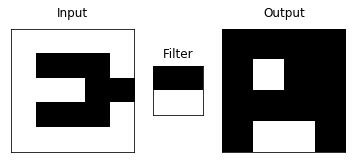

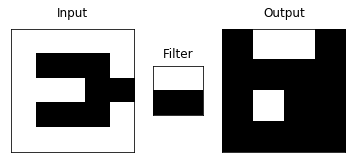

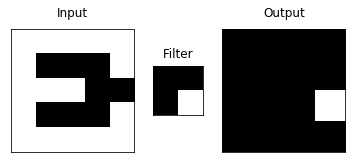

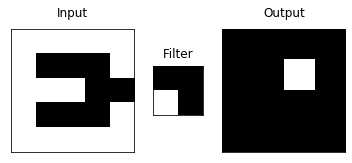

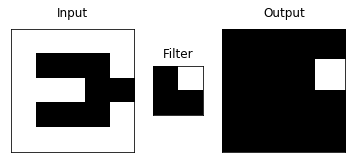

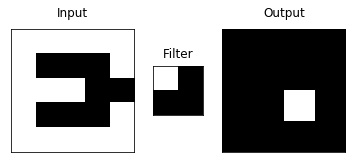

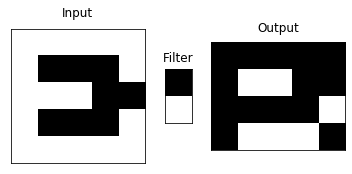

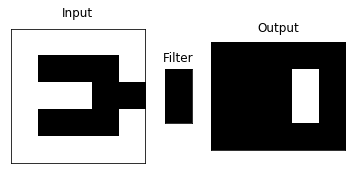

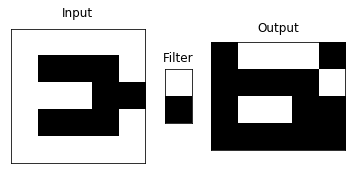

In [124]:
input = get_ship(5, 4)

for filter in edge_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in black_corner_filters:
    visualize_conv(input, filter, threshold = True)
    
for filter in filters_21:
    visualize_conv(input, filter, threshold = True)

## With padding

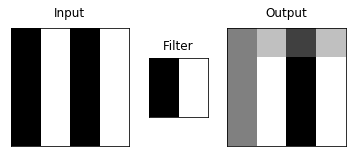

In [36]:
output = visualize_conv(v_stripes, v_edge_22, padding=True, full_wb_range=True)

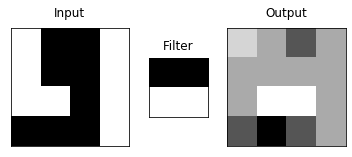

In [17]:
output = visualize_conv(get_edged_input(), h_edge_22, padding=True, full_wb_range=True)

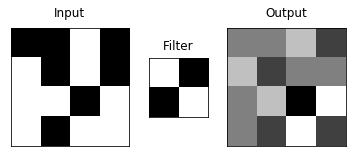

In [38]:
output = visualize_conv(get_rand_input(), diag_22, padding=True, full_wb_range=True)

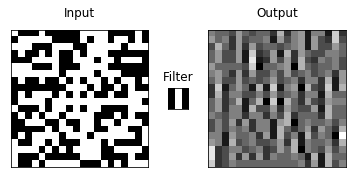

In [39]:
output = visualize_conv(get_rand_input(20), v_edge_33, padding=True, full_wb_range=True)

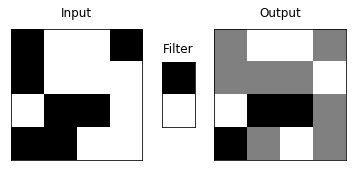

In [48]:
output = visualize_conv(get_rand_input(4), bw_21, padding=True, full_wb_range=True)

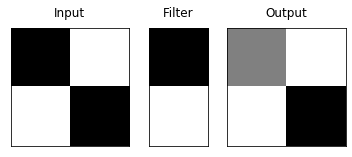

In [55]:
output = visualize_conv(get_rand_input(2), bw_21, padding=True, full_wb_range=True)

## Without padding

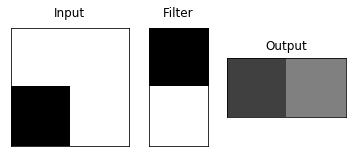

In [42]:
output = visualize_conv(get_rand_input(2), bw_21, padding=False, full_wb_range=False)

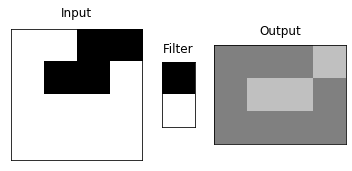

In [106]:
output = visualize_conv(get_rand_input(4), bw_21, padding=False, full_wb_range=False)

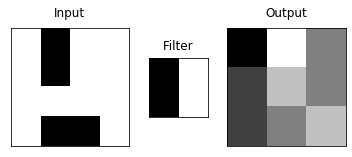

In [57]:
output = visualize_conv_no_pad(get_rand_input(4), v_edge_22, padding=False, full_wb_range=False)

[[-2]
 [ 0]]


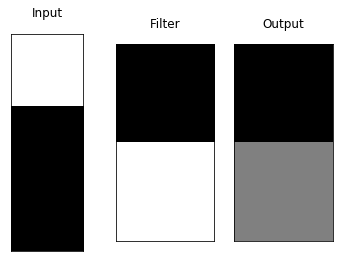

In [51]:
output = visualize_conv(get_rand_input((3,1)), bw_21, padding=False, full_wb_range=False)

print(output)

## 1D Input + Filters

array([[2],
       [0],
       [0]])

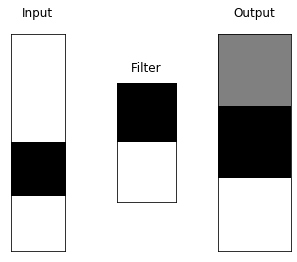

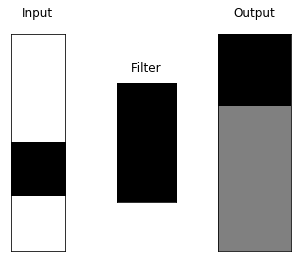

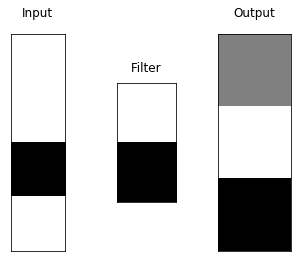

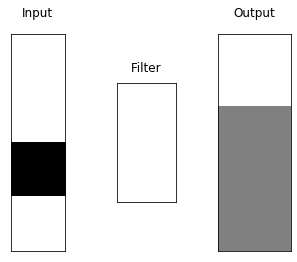

In [89]:
input = get_rand_input((4,1))

visualize_conv(input, bw_21, padding=False, full_wb_range=False)

visualize_conv(input, bb_21, padding=False, full_wb_range=False)

visualize_conv(input, wb_21, padding=False, full_wb_range=False)

visualize_conv(input, ww_21, padding=False, full_wb_range=False)

array([[ 1],
       [ 1],
       [ 1],
       [-1]])

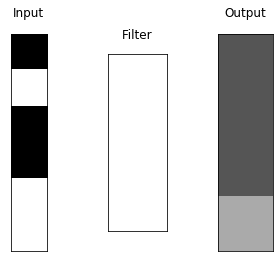

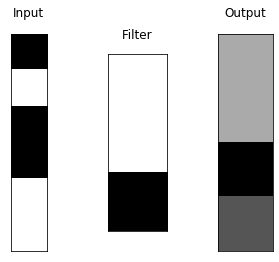

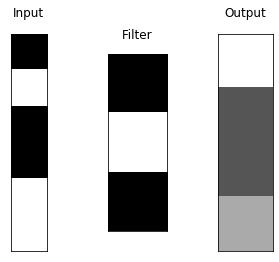

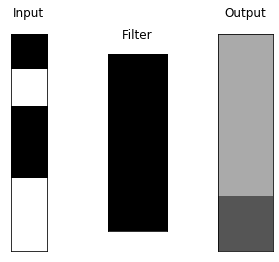

In [99]:
input = get_rand_input((6,1))

visualize_conv(input, www_31, padding=False, full_wb_range=False)

visualize_conv(input, wwb_31, padding=False, full_wb_range=False)

visualize_conv(input, bwb_31, padding=False, full_wb_range=False)

visualize_conv(input, bbb_31, padding=False, full_wb_range=False)

array([[ 1],
       [-1]])

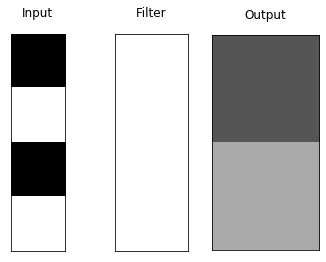

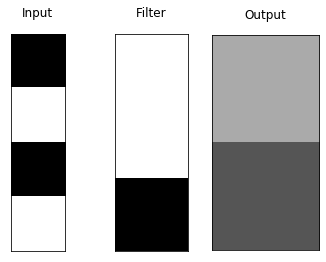

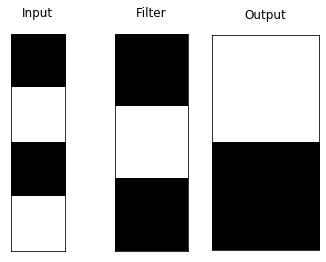

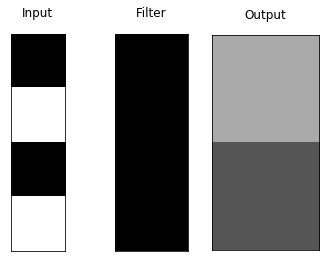

In [100]:
input = get_rand_input((4,1))

visualize_conv(input, www_31, padding=False, full_wb_range=False)

visualize_conv(input, wwb_31, padding=False, full_wb_range=False)

visualize_conv(input, bwb_31, padding=False, full_wb_range=False)

visualize_conv(input, bbb_31, padding=False, full_wb_range=False)

# Edged Input

array([[ 0.,  2.,  4.],
       [ 0.,  0., -2.],
       [ 0.,  0.,  0.]])

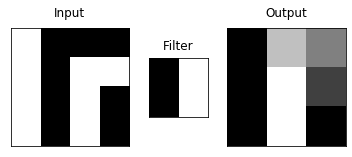

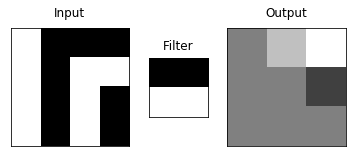

In [19]:
input = get_edged_input(4)

visualize_conv(input, v_edge_22, padding=False, full_wb_range=False)

visualize_conv(input, h_edge_22, padding=False, full_wb_range=False)

array([[-4., -2.,  0.],
       [ 2.,  4.,  0.],
       [ 0.,  0.,  0.]])

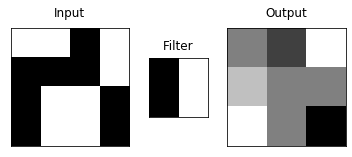

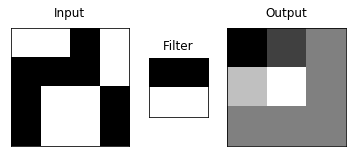

In [20]:
input = get_edged_input(4)

visualize_conv(input, v_edge_22, padding=False, full_wb_range=False)

visualize_conv(input, h_edge_22, padding=False, full_wb_range=False)

[[ 0.  2.  0.]
 [ 2.  0. -4.]
 [ 0.  0.  0.]]
[[ 0. -2.  0.]
 [-2.  0.  4.]
 [ 0.  0.  0.]]


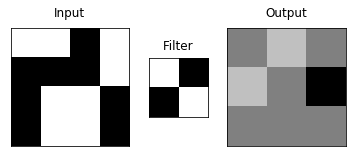

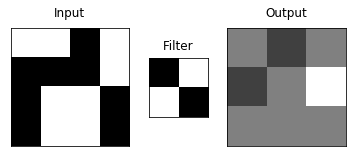

In [25]:
print(visualize_conv(input, diag1_22, padding=False, full_wb_range=False))

print(visualize_conv(input, diag2_22, padding=False, full_wb_range=False))   

[[ 0.  0.  0.]
 [ 4. -2.  2.]
 [ 0. -2.  0.]]
[[ 0.  0.  0.]
 [-4.  2. -2.]
 [ 0.  2.  0.]]


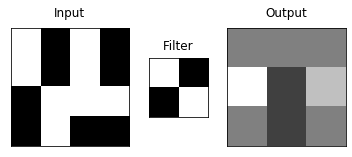

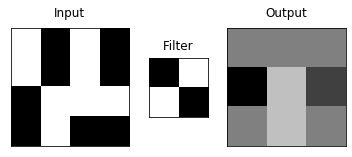

In [34]:
input = get_edged_input(4)

print(visualize_conv(input, diag1_22, padding=False, full_wb_range=False))

print(visualize_conv(input, diag2_22, padding=False, full_wb_range=False))   

array([[ 0.,  0.,  0.],
       [-2.,  0.,  2.],
       [ 4.,  0., -4.]])

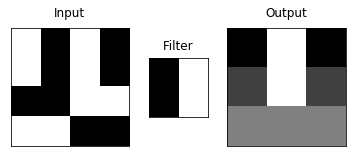

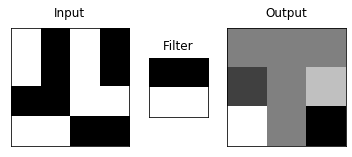

In [33]:
input = get_edged_input(4)

visualize_conv(input, v_edge_22, padding=False, full_wb_range=False)

visualize_conv(input, h_edge_22, padding=False, full_wb_range=False)

## With Threshold

array([[0, 0, 1],
       [0, 0, 0],
       [0, 0, 0]])

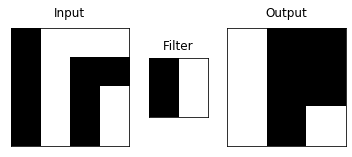

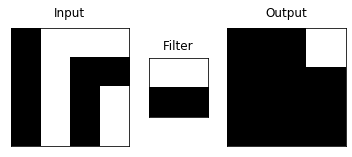

In [19]:
input = get_edged_input(4)

visualize_conv(input, v_edge_bw_22, threshold=True)
visualize_conv(input, h_edge_wb_22, threshold=True)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

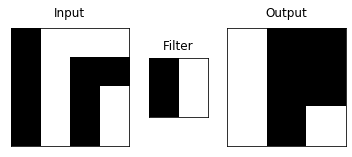

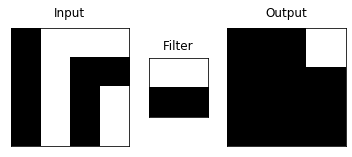

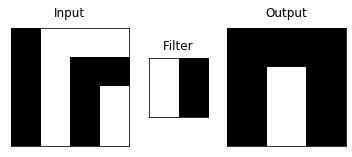

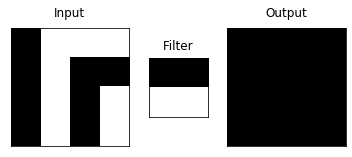

In [20]:
visualize_conv(input, v_edge_bw_22, threshold=True)
visualize_conv(input, h_edge_wb_22, threshold=True)
visualize_conv(input, v_edge_wb_22, threshold=True)
visualize_conv(input, h_edge_bw_22, threshold=True)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

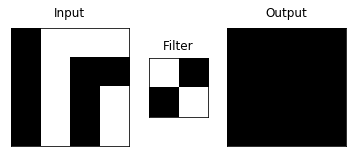

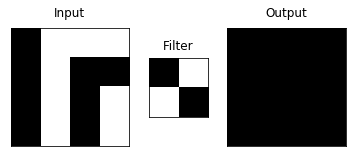

In [21]:
visualize_conv(input, diag1_22, threshold=True)
visualize_conv(input, diag2_22, threshold=True)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

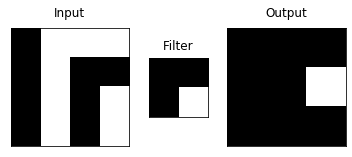

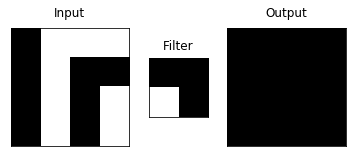

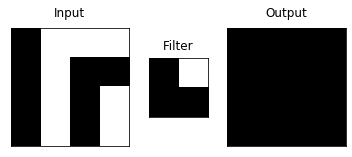

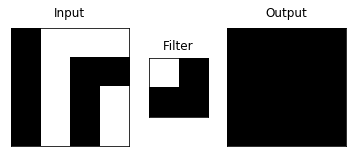

In [23]:
visualize_conv(input, corner_black_ul_22, threshold=True)
visualize_conv(input, corner_black_ur_22, threshold=True)
visualize_conv(input, corner_black_ll_22, threshold=True)
visualize_conv(input, corner_black_lr_22, threshold=True)